## **0. Download dataset**
**Note:** If you can't download using gdown due to limited number of downloads, please download it manually and upload it to your drive, then copy it from the drive to colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [ ]:
# https://drive.google.com/file/d/1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0/view?usp=drive_link
!gdown 1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0

Downloading...
From (original): https://drive.google.com/uc?id=1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0
From (redirected): https://drive.google.com/uc?id=1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0&confirm=t&uuid=fd55d0eb-4c20-49fc-9ae0-95b027b5b080
To: /content/img_cls_weather_dataset.zip
100% 613M/613M [00:05<00:00, 113MB/s] 


In [ ]:
!unzip img_cls_weather_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: weather-dataset/dataset/frost/3922.jpg  
  inflating: weather-dataset/dataset/frost/3923.jpg  
  inflating: weather-dataset/dataset/frost/3924.jpg  
  inflating: weather-dataset/dataset/frost/3925.jpg  
  inflating: weather-dataset/dataset/frost/3926.jpg  
  inflating: weather-dataset/dataset/frost/3927.jpg  
  inflating: weather-dataset/dataset/frost/3928.jpg  
  inflating: weather-dataset/dataset/frost/3929.jpg  
  inflating: weather-dataset/dataset/frost/3930.jpg  
  inflating: weather-dataset/dataset/frost/3931.jpg  
  inflating: weather-dataset/dataset/frost/3932.jpg  
  inflating: weather-dataset/dataset/frost/3933.jpg  
  inflating: weather-dataset/dataset/frost/3934.jpg  
  inflating: weather-dataset/dataset/frost/3935.jpg  
  inflating: weather-dataset/dataset/frost/3936.jpg  
  inflating: weather-dataset/dataset/frost/3937.jpg  
  inflating: weather-dataset/dataset/frost/3938.jpg  
  inflating: weather-dataset/da

## **1. Import libraries**

In [ ]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import LambdaLR

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

## **2. Read dataset**

In [ ]:
root_dir = 'weather-dataset/dataset'
classes = {
    label_idx: class_name \
        for label_idx, class_name in enumerate(
            sorted(os.listdir(root_dir))
        )
}

img_paths = []
labels = []
for label_idx, class_name in classes.items():
    class_dir = os.path.join(root_dir, class_name)
    for img_filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_filename)
        img_paths.append(img_path)
        labels.append(label_idx)

## **3. Train, val, test split**

In [ ]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

## **4. Create pytorch dataset**

In [ ]:
class WeatherDataset(Dataset):
    def __init__(
        self,
        X, y,
        transform=None
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, self.labels[idx]

## **5. Create data preprocessing function**

In [ ]:
def transform(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img = np.array(img)[..., :3]
    img = torch.tensor(img).permute(2, 0, 1).float()
    normalized_img = img / 255.0

    return normalized_img

## **6. Create dataloader**

In [ ]:
train_dataset = WeatherDataset(
    X_train, y_train,
    transform=transform
)
val_dataset = WeatherDataset(
    X_val, y_val,
    transform=transform
)
test_dataset = WeatherDataset(
    X_test, y_test,
    transform=transform
)

In [ ]:
train_batch_size = 8
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

Feature batch shape: torch.Size([4, 3, 224, 224])
Labels batch shape: torch.Size([4])


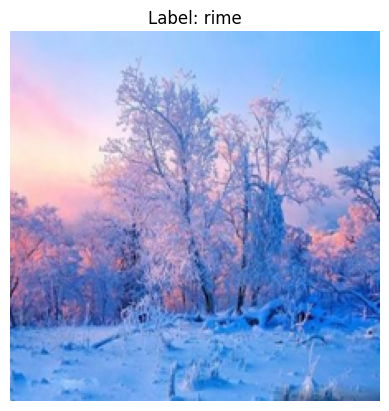

In [ ]:
train_features, train_labels = next(iter(train_loader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[0].permute(1, 2, 0)
label = train_labels[0].item()
plt.imshow(img)
plt.axis('off')
plt.title(f'Label: {classes[label]}')
plt.show()

In [ ]:
classes

{0: 'dew',
 1: 'fogsmog',
 2: 'frost',
 3: 'glaze',
 4: 'hail',
 5: 'lightning',
 6: 'rain',
 7: 'rainbow',
 8: 'rime',
 9: 'sandstorm',
 10: 'snow'}

## **7. Create model**

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, stride=stride, padding=1
        )
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1, padding=1
        )
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels,
                    kernel_size=1, stride=stride
                ),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()

    def forward(self, x):
        shortcut = self.downsample(x)
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)

        feature_map = x

        x = self.conv2(x)
        x = self.batch_norm2(x)
        x += shortcut
        x = self.relu(x)

        return x, feature_map

In [ ]:
class ResNet(nn.Module):
    def __init__(self, residual_block, n_blocks_lst, n_classes):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = self.create_layer(residual_block, 64, 64, n_blocks_lst[0], 1)
        self.conv3 = self.create_layer(residual_block, 64, 128, n_blocks_lst[1], 2)
        self.conv4 = self.create_layer(residual_block, 128, 256, n_blocks_lst[2], 2)
        self.conv5 = self.create_layer(residual_block, 256, 512, n_blocks_lst[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, n_classes)

    def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
        blocks = []
        first_block = residual_block(in_channels, out_channels, stride)
        blocks.append(first_block)

        for idx in range(1, n_blocks):
            block = residual_block(out_channels, out_channels, stride=1)
            blocks.append(block)

        block_sequential = nn.Sequential(*blocks)

        return block_sequential


    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        feature_maps = []

        # Process through conv2 to conv5
        for layer in [self.conv2, self.conv3, self.conv4, self.conv5]:
            for block in layer:
                x, feature_map = block(x)

                if layer in [self.conv5]:
                    feature_maps.append(feature_map)

        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)

        return x, feature_maps

In [ ]:
# https://drive.google.com/file/d/1DeHv1GD3qT2DgtlRVkDh01aRillGrP35/view?usp=sharing

### Uncomment the below code to download the teacher model (in case you forgot or lost the file model.pt)
!gdown 1DeHv1GD3qT2DgtlRVkDh01aRillGrP35

Downloading...
From (original): https://drive.google.com/uc?id=1DeHv1GD3qT2DgtlRVkDh01aRillGrP35
From (redirected): https://drive.google.com/uc?id=1DeHv1GD3qT2DgtlRVkDh01aRillGrP35&confirm=t&uuid=506cb74d-bd7b-4186-b9bb-72062532720e
To: /content/teacher_wt.pt
100% 85.3M/85.3M [00:00<00:00, 215MB/s]


In [ ]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

teacher_model = ResNet(
    residual_block=ResidualBlock,
    n_blocks_lst=[3, 4, 6, 3],
    n_classes=n_classes
).to(device)

teacher_model.load_state_dict(
    torch.load(
        'teacher_wt.pt',
        map_location=device
    )
)

student_model = ResNet(
    residual_block=ResidualBlock,
    n_blocks_lst=[2, 2, 2, 2],
    n_classes=n_classes
).to(device)

<ipython-input-16-7dcc291ab66a>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


In [ ]:
teacher_model.eval()
student_model.eval()

dummy_tensor = torch.randn(1, 3, 224, 224).to(device)

with torch.no_grad():
    teacher_output = teacher_model(dummy_tensor)
    student_output = student_model(dummy_tensor)

print('Teacher output shape:', teacher_output[0].shape, len(teacher_output[1]))
print('Student output shape:', student_output[0].shape, len(student_output[1]))

Teacher output shape: torch.Size([1, 11]) 3
Student output shape: torch.Size([1, 11]) 2


## **8. Training**

In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [ ]:
def compute_rkd_loss(features_teacher, features_student):
    # Distance loss
    diff_teacher = features_teacher.unsqueeze(1) - features_teacher.unsqueeze(0)
    diff_student = features_student.unsqueeze(1) - features_student.unsqueeze(0)

    distance_teacher = torch.norm(diff_teacher, dim=-1)
    distance_student = torch.norm(diff_student, dim=-1)
    distance_loss = F.mse_loss(distance_student, distance_teacher)

    # Angle loss
    cosine_teacher = F.cosine_similarity(diff_teacher.unsqueeze(2), diff_teacher.unsqueeze(3), dim=-1)
    cosine_student = F.cosine_similarity(diff_student.unsqueeze(2), diff_student.unsqueeze(3), dim=-1)
    angle_loss = F.mse_loss(cosine_student, cosine_teacher)

    return distance_loss, angle_loss

In [ ]:
def fit(
    teacher, student, train_loader,
    val_loader, optimizer, criterion,
    scheduler, device, epochs, alpha=0.5,
    beta=0.5, gamma=1.0, T=2
):
    train_losses = []
    val_losses = []
    val_accs = []
    teacher.eval()

    for epoch in range(epochs):
        batch_train_losses = []

        student.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.no_grad():
                teacher_logits, teacher_features = teacher_model(inputs)
            student_logits, student_features = student_model(inputs)

            # Compute RKD losses
            distance_loss, angle_loss = compute_rkd_loss(teacher_features[-1], student_features[-1])

            # Compute soft targets loss
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)

            # Combine all losses
            loss = alpha * distance_loss + beta * angle_loss + gamma * soft_targets_loss

            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            student, val_loader,
            criterion, device
        )
        val_accs.append(val_acc)
        val_losses.append(val_loss)
        scheduler.step()

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal acc: {val_acc:.4f}')

    return train_losses, val_losses, val_accs

In [ ]:
lr = 1e-2
epochs = 30

def lr_lambda(epoch, warmup_epochs=5, total_epochs=30, init_scale=0.1, min_scale=0.3):
    scale_range = 1.0 - min_scale

    if epoch < warmup_epochs:
        warmup_factor = epoch / warmup_epochs
        return init_scale + (1.0 - init_scale) * warmup_factor

    decay_factor = (total_epochs - epoch) / (total_epochs - warmup_epochs)
    return min_scale + scale_range * max(0.0, decay_factor)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    student_model.parameters(),
    lr=lr
)

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

In [ ]:
for epoch in range(epochs):
    print(f'Epoch {epoch}, LR: {lr * lr_lambda(epoch):.6f}')

Epoch 0, LR: 0.001000
Epoch 1, LR: 0.002800
Epoch 2, LR: 0.004600
Epoch 3, LR: 0.006400
Epoch 4, LR: 0.008200
Epoch 5, LR: 0.010000
Epoch 6, LR: 0.009720
Epoch 7, LR: 0.009440
Epoch 8, LR: 0.009160
Epoch 9, LR: 0.008880
Epoch 10, LR: 0.008600
Epoch 11, LR: 0.008320
Epoch 12, LR: 0.008040
Epoch 13, LR: 0.007760
Epoch 14, LR: 0.007480
Epoch 15, LR: 0.007200
Epoch 16, LR: 0.006920
Epoch 17, LR: 0.006640
Epoch 18, LR: 0.006360
Epoch 19, LR: 0.006080
Epoch 20, LR: 0.005800
Epoch 21, LR: 0.005520
Epoch 22, LR: 0.005240
Epoch 23, LR: 0.004960
Epoch 24, LR: 0.004680
Epoch 25, LR: 0.004400
Epoch 26, LR: 0.004120
Epoch 27, LR: 0.003840
Epoch 28, LR: 0.003560
Epoch 29, LR: 0.003280


In [ ]:
train_losses, val_losses, val_accs = fit(
    teacher_model, student_model, train_loader, val_loader, optimizer, criterion, scheduler,
    device, epochs, alpha=0.5, beta=0.5, gamma=1.0, T=2
)

EPOCH 1:	Train loss: 4.3645	Val loss: 1.3880	Val acc: 0.5666
EPOCH 2:	Train loss: 3.5858	Val loss: 1.6245	Val acc: 0.5251
EPOCH 3:	Train loss: 3.2539	Val loss: 2.2116	Val acc: 0.5412
EPOCH 4:	Train loss: 2.9271	Val loss: 1.3898	Val acc: 0.6256
EPOCH 5:	Train loss: 2.7077	Val loss: 4.4467	Val acc: 0.2819
EPOCH 6:	Train loss: 2.7374	Val loss: 5.9956	Val acc: 0.1428
EPOCH 7:	Train loss: 4.5493	Val loss: 3.3484	Val acc: 0.3270
EPOCH 8:	Train loss: 4.0299	Val loss: 1.7156	Val acc: 0.5237
EPOCH 9:	Train loss: 3.4716	Val loss: 1.8876	Val acc: 0.5055
EPOCH 10:	Train loss: 3.1800	Val loss: 1.5198	Val acc: 0.5441
EPOCH 11:	Train loss: 2.9747	Val loss: 1.3722	Val acc: 0.6082
EPOCH 12:	Train loss: 2.8251	Val loss: 1.2862	Val acc: 0.6278
EPOCH 13:	Train loss: 2.6907	Val loss: 3.4498	Val acc: 0.2819
EPOCH 14:	Train loss: 2.5489	Val loss: 1.1706	Val acc: 0.6446
EPOCH 15:	Train loss: 2.9372	Val loss: 1.6191	Val acc: 0.5710
EPOCH 16:	Train loss: 2.7405	Val loss: 1.3811	Val acc: 0.6082
EPOCH 17:	Train l

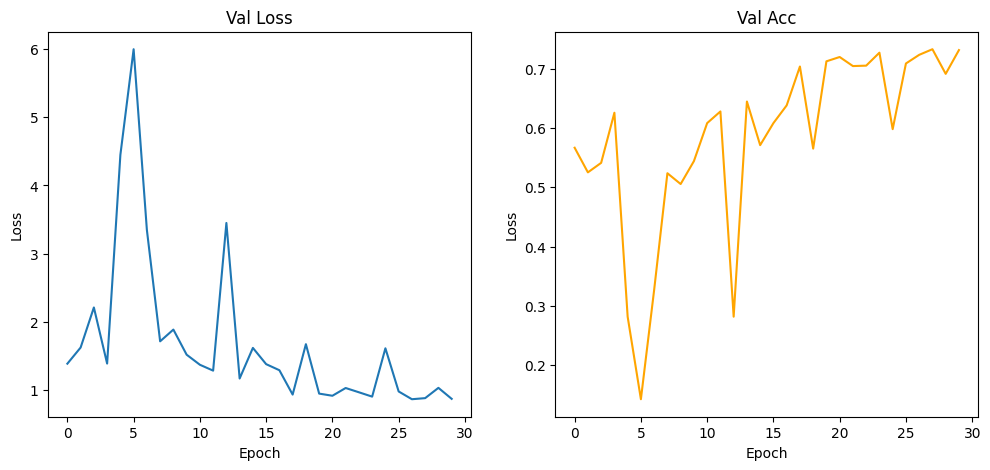

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(val_losses)
ax[0].set_title('Val Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_accs, color='orange')
ax[1].set_title('Val Acc')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

## **9. Evaluation**

In [ ]:
val_loss, val_acc = evaluate(
    student_model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    student_model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.7312454479242535
Test accuracy:  0.735080058224163


## **10. Download the model**

In [ ]:
save_path = 'rkd_samedata_wt.pt'
torch.save(student_model.state_dict(), save_path)